In [1]:
import csv
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
from scipy.optimize import minimize, fmin_tnc
from tkinter import *
from tkinter import ttk
import math
from geneticalgorithm import geneticalgorithm as ga

In [2]:
def doTheRest():
    with open(course_path, newline='') as file:
        data = list(csv.reader(file))
    del data[0]
    global courseArray
    courseArray = []
    for course in data:
        courseArray.append(course[1])
    

    global semesters
    semesters = {"numbers": [-1, 101, 102, 103, 201, 202, 203, 301, 302, 303, 401, 402],
                 "names": ["Just finished prepyear",
                           "Freshman 1st semester", "Freshman 2nd semester", "Freshman summer session",
                           "Sophomore 1st semester", "Sophomore 2nd semester", "Sophomore summer session",
                           "Junior 1st semester", "Junior 2nd semester", "Junior summer training",
                           "Senior 1st semester", "Senior 2nd semester"]}
    
    with open(train_dataset_path, newline='') as file_w:
      data_w = list(csv.reader(file_w))
    del data_w[0]

    temp_list_courses = []
    for course_w in data_w:
      name = course_w[0]
      credit = float(course_w[1])
      lab = float(course_w[2])
      difficulty = float(course_w[3])
      material = float(course_w[4])
      study_time = float(course_w[5])
      weight = (credit+lab)*(difficulty*material*study_time/1000)
      temp_list_courses.append([name, weight])

    global selectCourses
#--------------------------------------------------------------------------
    def genetic_Algorithm(remaining_hours,termNumber, term):
      def getFitnessValue(chromosome):
        
        chromosome = chromosome.astype(np.int64)
        chromosome = np.unique(chromosome, axis=0)

        total_w = 0
        total_c = 0

        easy = 0
        hard = 0
        for x in chromosome:
          if x!=-1:
            total_w = total_w + term[x].weight
            total_c = total_c + term[x].credit
            if term[x].difficulty == 1:
                easy = easy + 1
            elif term[x].difficulty == 3:
                hard = hard + 1
        
        fitnessValue = total_c * total_w
        
        if (total_c)<remaining_hours-2:
            fitnessValue = 1000000
        elif (total_c)<remaining_hours:
            fitnessValue = pow(fitnessValue,remaining_hours-total_c)
        elif (total_c)>remaining_hours+2:
            fitnessValue = 10000000
        elif (total_c)>remaining_hours:
            fitnessValue = pow(fitnessValue,total_c-remaining_hours)
        else:
            fitnessValue = total_c * total_w
        
        if easy>1:
            fitnessValue = pow(fitnessValue,easy)
        
        if hard>2:
            fitnessValue = pow(fitnessValue,hard-1)
        
        return fitnessValue
    #****************************************************************
      
      num_courses = len(term)
      varbound=np.array([[-1,num_courses-1]]*num_courses)
      
      algorithm_param = {'max_num_iteration': None,
                      'population_size':100,
                      'mutation_probability':0.1,
                      'elit_ratio': 0.01,
                      'crossover_probability': 0.5,
                      'parents_portion': 0.3,
                      'crossover_type':'uniform',
                      'max_iteration_without_improv':None}
                      
      model= ga(
          function=getFitnessValue,
          dimension=num_courses,
          variable_type='int',
          variable_boundaries=varbound)
      
      hours = 0
    
      if remaining_hours < 6:
        x = remaining_hours
        i=0
        while x>0 and i<len(term):
            if term[i].credit<remaining_hours+2:
                term[i].term = termNumber
                term[i].available = False
                x = x - term[i].credit
            i+=1      
      else:
        model.run()
        
        bestCourses = model.best_variable
        bestCourses = np.unique(bestCourses, axis=0)
        bestCourses = bestCourses.astype(np.int64)
        
        for x in bestCourses:
            if x!=-1:
                term[x].term = termNumber
                hours = hours + term[x].credit
                term[x].available = False
      
      return hours

#--------------------------------------------------------------------------
    def selectCourses(semesterInfo, term, root, rcIndexes):
      termNumber = semesterInfo[0]
      termHours = semesterInfo[1]

      if termHours==0:
        return 0

      hours = 0

      if termNumber==402:
        for co in courses:
          if co.term==-1:
            co.term=termNumber
            co.mandatory = False
            co.available = False
            hours += co.credit
      else:
        for co in courses:
          if co.mandatory and (hours+co.credit)<=termHours+2:
            co.term = termNumber
            co.available = False
            hours += co.credit
            co.mandatory = False
            if co in term:
                term.remove(co)
        remaining_hours = termHours-hours
        if remaining_hours > 0:
            hours = hours + genetic_Algorithm(remaining_hours,termNumber, term)

      printTerm(termNumber,termHours, root, rcIndexes)
      return hours
    
#--------------------------------------------------------------------------
    def printTerm(termIndex, termHours, root, rcIndexes):
      count = 0
      
      tv = ttk.Treeview(root, selectmode ='browse')
      tv["columns"] = ("1", "2", "3")
      tv['show'] = 'headings'
      tv.column("1", width = 90, anchor ='c') 
      tv.column("2", width = 90, anchor ='se') 
      tv.column("3", width = 90, anchor ='se') 
      tv.heading("1", text ="Course") 
      tv.heading("2", text ="Credit") 
      tv.heading("3", text ="Difficulty") 
      
      for x in courses:
        if x.term == termIndex:
          tv.insert("", 'end', values =(x.name, x.credit, x))
          count += x.credit
      
      r0,c0=rcIndexes[0]
      Label(root, text="Term{}\t|Total hours = {}/{}".format(termIndex,count,termHours)).grid(row=r0,column=c0, sticky='snew')
      r1,c1=rcIndexes[1]
      tv.grid(row=r1,column=c1, sticky='snew')
    
#--------------------------------------------------------------------------
    global updateCourses
    def updateCourses(currentYear, currentTermIndex, term, summerState):
      for x in courses:
        if x.setAvailable(currentYear, currentTermIndex, summerState):
          term.append(x)
#--------------------------------------------------------------------------
    #enter the courses as objects
    global courses
    courses = []
    global Total_Credit
    Total_Credit=0
    for course in data:
      #course data
      order = int(course[0])
      name = course[1]
      level = int(course[2])
      credit = int(course[3])
      preIndex = int(course[4])
      summer = False
      if int(course[5])==1: #[5] summer or not
        summer = True

      #prerequist course
      prerequisite = None
      if preIndex != 0:
        prerequisite = courses[preIndex-1]

      #add new course
      courses.append(Course(order,name, level, credit, prerequisite, summer))
      Total_Credit = Total_Credit + credit

    for co in courses:
      counter = 0
      weight = 0
      for co_w in temp_list_courses:
        if co_w[0]==co.name:
          counter = counter + 1
          weight = weight + co_w[1]
      co.setWeight(weight/counter)

    courses.sort(key=lambda x: x.weight)
    for i in range(len(courses)):
      if i<12:
        courses[i].setDifficulty(1)
      elif i>(len(courses)-12):
        courses[i].setDifficulty(3)
      else:
        courses[i].setDifficulty(2)
    
    courses.sort(key=lambda x: x.order)

In [3]:
class Course:
  def __init__(self, order, name, level, credit, prerequisite, Summer):
    self.order = order
    self.term = -1
    self.isFinished = False
    if level==1:
      self.depth = 7
    elif level==2:
      self.depth = 4
    elif level==3:
      self.depth = 1
    else:
      self.depth = 1
    self.mandatory = False
    self.name = name
    self.level = level
    self.credit = credit
    self.Summer = Summer
    self.prerequisite = prerequisite
    if prerequisite:
      self.prerequisite.setDepth(2)
      self.available = False
    else:
      if level < 3:
        self.available = True
      else:
        self.available = False
#--------------------------------------------------------------------------  
  def setWeight(self, weight):
    self.weight = weight
    
#--------------------------------------------------------------------------
  def setDifficulty(self, difficulty):
    self.difficulty = difficulty;
#--------------------------------------------------------------------------
  def setFinished(self):
    self.isFinished = True
    self.available = False
    if self.prerequisite:
        self.prerequisite.setFinished()
#--------------------------------------------------------------------------
  def setDepth(self, depth):
    if self.depth < depth:
      self.depth = depth
      if self.prerequisite:
        self.prerequisite.setDepth(depth+1)
#--------------------------------------------------------------------------
  def setMandatory(self, depth, termIndex, summerState):
    temp = depth
    extra = 0

    if not self.Summer or not summerState:
      if temp%2 != 0:
        temp += 1

      extra = (temp/2) - 1
      depth = depth + extra
    elif summerTraining and depth>2:
      depth += 1

    currentYear = (termIndex//3)+1

    if (11-depth)==termIndex:
      self.mandatory = True
    elif (termIndex+2)%3==0 and (((termIndex+2)//3)-1)==self.level:
      self.mandatory = True
    
    if self.prerequisite:
      if self.prerequisite.term==-1:
        self.mandatory = False
        
#--------------------------------------------------------------------------
  def setAvailable(self, CurrentYear, termIndex, summerState):
    
    #finished
    if self.isFinished or self.term!=-1:
      self.available = False
      return False

    #not available for summer
    if (termIndex+1)%3==0 and not self.Summer:
      self.available = False
      return False

    #not available for term level
    if (self.level-CurrentYear)>1:
      self.available = False
      return False
    
    #setMandatory 
    self.setMandatory(self.depth,termIndex, summerState)

    if self.mandatory:
      self.available = True
      return True
    
    if not self.prerequisite:
      self.available = True
      return True
    elif self.prerequisite.term!=-1:
      self.available = True
      return True
    else:
      self.available = False
      return False
#-------------------------------------------------------------------------- 
  def __str__(self):
    if self.difficulty==1:
      return "Easy"
    elif self.difficulty==2:
      return "Normal"
    else:
      return "Hard"

In [4]:
def doCheckbuttons(root, array, vars, index):
    rowsNum = math.ceil(len(array)/4)
    for i in range(len(array)):
        vars.append(BooleanVar())
        if i < rowsNum:
            Checkbutton(root, text=array[i], variable=vars[-1], onvalue=True, offvalue=False).grid(row=(i%rowsNum)+index,column=0, sticky='snew')
        elif i < rowsNum*2:
            Checkbutton(root, text=array[i], variable=vars[-1], onvalue=True, offvalue=False).grid(row=(i%rowsNum)+index,column=1, sticky='snew')
        elif i < rowsNum*3:
            Checkbutton(root, text=array[i], variable=vars[-1], onvalue=True, offvalue=False).grid(row=(i%rowsNum)+index,column=2, sticky='snew')
        else:
            Checkbutton(root, text=array[i], variable=vars[-1], onvalue=True, offvalue=False).grid(row=(i%rowsNum)+index,column=3, sticky='snew')
#--------------------------------------------------------------------------
def doB1(FilteredCourses, lastSemester, summerState, root, r1):
    Label(r1, text="Your academic schedule is on the right --->").grid(row=16,column=0,columnspan=4, sticky='snew')
    doSubmit(FilteredCourses, lastSemester, summerState, root)
#--------------------------------------------------------------------------
def doSubmit(FilteredCourses, lastSemester, summerState, root):
    root.grid(row=0,column=1,sticky='snew')
    i = 0;
    global completed_Credit
    completed_Credit = 0;
    for course in courses:
      isFinished = FilteredCourses[i]
      if(isFinished):
        course.term = 100
        course.setFinished()
        completed_Credit = completed_Credit + course.credit
      i+=1
      
    
    Label(root, text="Hours finished = {}".format(completed_Credit)).grid(row=0,column=0,columnspan=4, sticky='snew')
    remaining_Credit = Total_Credit - completed_Credit

    if summerState:
      num_summers = 1
      remaining_semesters = 8 - (lastSemester - lastSemester//3)
      summer_credit = 6
      semester_credit = ((remaining_Credit-(summer_credit*num_summers))//remaining_semesters)
      missing_credit = remaining_Credit - (semester_credit * remaining_semesters) - (summer_credit*num_summers)
    else:
      summer_credit = 0
      remaining_semesters = 8 - (lastSemester - lastSemester//3)
      semester_credit = (remaining_Credit//remaining_semesters)
      missing_credit = remaining_Credit - (semester_credit * remaining_semesters)

    semesterName = [101,102,103,201,202,203,301,302,303,401,402]
    semester = []
    for i in range(len(semesterName)):
      if (i+1)<=lastSemester:
        semester.append([semesterName[i],0])
      elif (i+1)%3==0 and (i+1)!=9:
        semester.append([semesterName[i],summer_credit])
      elif (i+1)%3==0 and (i+1)==9:
        semester.append([semesterName[i],0])
      else:
        if missing_credit>0:
          semester.append([semesterName[i],semester_credit+1])
          missing_credit = missing_credit - 1
        else:
          semester.append([semesterName[i],semester_credit])
    
    global summerTraining
    if semester[8][1]==0:
      summerTraining = True
    else:
      summerTraining = False

    totalHours = 0
    rcIndexes = [[(1,0),(2,0)],[(3,0),(4,0)],[(5,0),(6,0)],
                 [(1,1),(2,1)],[(3,1),(4,1)],[(5,1),(6,1)],
                 [(1,2),(2,2)],[(3,2),(4,2)],[(5,2),(6,2)],
                 [(1,3),(2,3)],[(3,3),(4,3)]]
    for termIndex in range(len(semester)):
      term = []
      currentYear = (termIndex//3)+1
      updateCourses(currentYear,termIndex,term, summerState)
      termHours = selectCourses(semester[termIndex], term, root, rcIndexes[termIndex])
      temp_Hours = semester[termIndex]
      if termHours<temp_Hours[1] and termIndex<=len(semester)-2:
        if semester[termIndex+1][1]>0:
          semester[termIndex+1][1] = semester[termIndex+1][1] + 1
        elif termIndex<len(semester)-2:
          semester[termIndex+2][1] = semester[termIndex+2][1] + 1
      totalHours = totalHours + termHours
    
    totalHours = totalHours + completed_Credit
    totalHours = 132
    Label(root, text="Total Hours = {}".format(totalHours)).grid(row=7,column=0,columnspan=4, sticky='snew')
#--------------------------------------------------------------------------
def noSummer(var):
    global noSummer
    noSummer = False
    for i in range(6, len(semesters['names'])):
        if semesters['names'][i] == var.get():
            noSummer = True
    return noSummer
#--------------------------------------------------------------------------
def lastSemester(var):
    for i in range(len(semesters['names'])):
        if semesters['names'][i] == var.get():
            return i
#--------------------------------------------------------------------------
def FilteredCourses(vars):
    array = []
    for var in vars:
        array.append(var.get())
    return array
#--------------------------------------------------------------------------
def doB2Yes(l, b1, b2, v):
    global noSummer
    if noSummer(v):
        l.config(text="You cannot! you have already taken all available summer sessions.")
        noSummer = True
    else:
        l.config(text="You have asked to take summer sessions!")
        noSummer = False
    b1.grid_forget()
    b2.grid_forget()
#--------------------------------------------------------------------------
def doB2No(l, b1, b2, v):
    global noSummer
    noSummer = True
    l.config(text="You have refused to take summer sessions!")
    b1.grid_forget()
    b2.grid_forget()
#--------------------------------------------------------------------------
def doCHE(r, root):
    global course_path
    global train_dataset_path
    course_path = 'CHE_Main_Plan.csv'
    train_dataset_path = 'CHE_Train_Dataset.csv'
    r.pack_forget()
    doRest(root)
#--------------------------------------------------------------------------
def doME(r, root):
    global course_path
    global train_dataset_path
    course_path = 'ME_Main_Plan.csv'
    train_dataset_path = 'ME_Train_Dataset.csv'
    r.pack_forget()
    doRest(root)
#--------------------------------------------------------------------------
def doSWE(r, root):
    global course_path
    global train_dataset_path
    course_path = 'SWE_Main_Plan.csv'
    train_dataset_path = 'SWE_Train_Dataset.csv'
    r.pack_forget()
    doRest(root)
#--------------------------------------------------------------------------
def doRest(root):
    doTheRest()
    root1 = Frame(root, width=200, height=200, relief=RIDGE)
    root1.grid(row=0,column=0,sticky='snew')
    Label(root1, text="Please select the courses you have finished:").grid(row=0,column=0,columnspan=4, sticky='snew')
    finishedCourseVars = []
    doCheckbuttons(root1, courseArray, finishedCourseVars, 1)
    Label(root1, text="Please select your academic standing and last semester you have finished:").grid(row=12,column=0,columnspan=4, sticky='snew')
    OptionMenuVar = StringVar()
    OptionMenuVar.set(semesters['names'][0])
    OptionMenu(root1, OptionMenuVar, *semesters['names']).grid(row=13,column=0,columnspan=4, sticky='sn')
    label = Label(root1, text="Would you like to take summer sessions?")
    label.grid(row=14,column=0,columnspan=4, sticky='snew')
    b2y = Button(root1, text='Yes')
    b2y.grid(row=15,column=0,columnspan=2, sticky='sn')
    b2n = Button(root1, text='No')
    b2n.grid(row=15,column=2,columnspan=2, sticky='sn')
    b2y.config(command=lambda: doB2Yes(label, b2y, b2n, OptionMenuVar))
    b2n.config(command=lambda: doB2No(label, b2y, b2n, noSummer))
    root2 = Frame(root, width=200, height=200, relief=RIDGE)
    Button(root1, text='submit', command=lambda: doB1(FilteredCourses(finishedCourseVars), lastSemester(OptionMenuVar), not noSummer, root2, root1)).grid(row=16,column=0,columnspan=4, sticky='sn')

In [5]:
root = Tk()
root.title("AI academic scheduling advisor")
#change start
root0 = Frame(root, width=200, height=200, relief=RIDGE)
root0.pack()
label = Label(root0, text="Please select your major:")
label.grid(row=0,column=0,columnspan=3, sticky='snew')
bCHE = Button(root0, text='CHE')
bCHE.grid(row=1,column=0, sticky='sn')
bME = Button(root0, text='ME')
bME.grid(row=1,column=1, sticky='sn')
bSWE = Button(root0, text='SWE')
bSWE.grid(row=1,column=2, sticky='sn')
bCHE.config(command=lambda: doCHE(root0, root))
bME.config(command=lambda: doME(root0, root))
bSWE.config(command=lambda: doSWE(root0, root))

101 >>> Mandatory hours=  0
101 >>>> remaining_hours =  17
 The best solution found:                                                                           
 [ 6.  2.  3.  7.  1.  1.  1. -1.]

 Objective function:
 6640.03338496


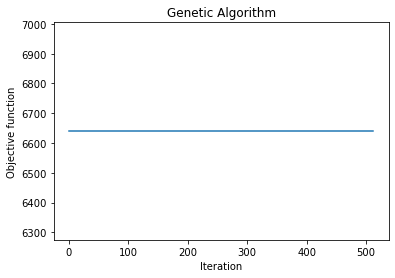

102 >>> Mandatory hours=  18
201 >>> Mandatory hours=  0
201 >>>> remaining_hours =  17
 The best solution found:                                                                           
 [ 8.  5. -1.  9.  5.  8.  7.  7.  3.  9.  9.]

 Objective function:
 50.20266666666667


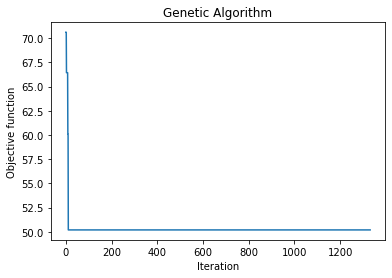

202 >>> Mandatory hours=  1
202 >>>> remaining_hours =  17
 The best solution found:                                                                           
 [10. -1. -1.  8. 10.  7.  5.  7.  8.  2. -1.]

 Objective function:
 34.834133333333334


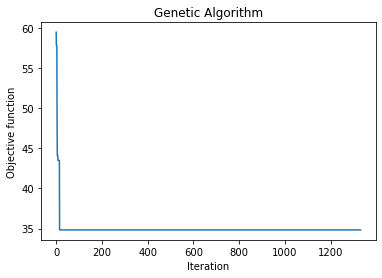

301 >>> Mandatory hours=  14
301 >>>> remaining_hours =  3
302 >>> Mandatory hours=  3
302 >>>> remaining_hours =  14
 The best solution found:                                                                           
 [-1. 10.  4. 10. 12. 10.  4. 10.  3.  3. 10.  4.  4.]

 Objective function:
 33.58810000000001


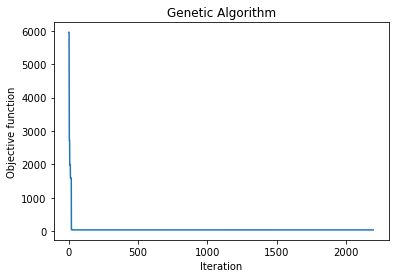

401 >>> Mandatory hours=  3
401 >>>> remaining_hours =  14
 The best solution found:                                                                           
 [7. 7. 3. 7. 7. 6. 3. 3. 8.]

 Objective function:
 55.4671


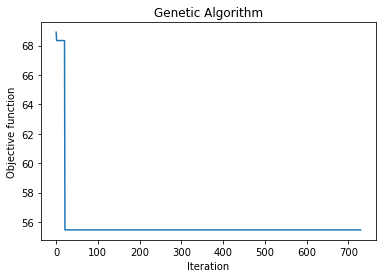

In [6]:
root.mainloop()